nr of spikes: 0


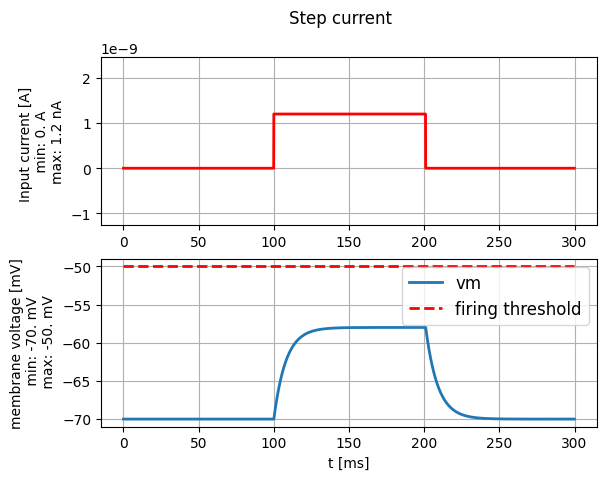

nr of spikes: 5


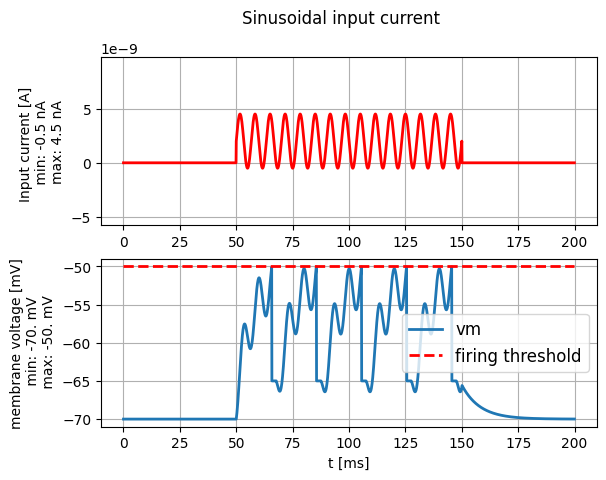

Resting potential: -70. mV
Reset voltage: -65. mV
Firing threshold: -50. mV
Membrane resistance: 10. Mohm
Membrane time-scale: 8. ms
Absolute refractory period: 2. ms


In [7]:
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
from neurodynex3.leaky_integrate_and_fire import LIF
from neurodynex3.tools import input_factory, plot_tools

V_REST = -70. * b2.mV
V_RESET = -65. * b2.mV
FIRING_THRESHOLD = -50. * b2.mV
MEMBRANE_RESISTANCE = 10. * b2.Mohm
MEMBRANE_TIME_SCALE = 8. * b2.ms
ABSOLUTE_REFRACTORY_PERIOD = 2.0 * b2.ms

LIF.getting_started()
LIF.print_default_parameters()

### 1.1.1 Question: Minimal Current (Calculation)

For the default neuron parameters (see above), compute the minimal amplitude $I_{min}$ of a step current to elicitate a spike. You can access the default values in your code and do the calculation with correct units:

In [15]:
from neurodynex3.leaky_integrate_and_fire import LIF
print("resting potential: {}".format(LIF.V_REST))

# From Exercise Set 1, I0 was computed to be:
I_min = (FIRING_THRESHOLD - V_REST) / MEMBRANE_RESISTANCE
print("I_min: {}".format(I_min))


resting potential: -70. mV
I_min: 2. nA


### 1.1.2 Question: Minimal Current (Simulation)

Use the value $I_{min}$ you've computed and verify your result: inject a step current of amplitude $I_{min}$ for 100ms into the LIF neuron and plot the membrane voltage. ``vm`` should approach the firing threshold but **not** fire. We have implemented a couple of helper functions to solve this task. Use this code block, but make sure you understand it and you've read the docs of the functions `.LIF.simulate_LIF_neuron`, `.input_factory.get_step_current` and `.plot_tools.plot_voltage_and_current_traces`.


nr of spikes: 0


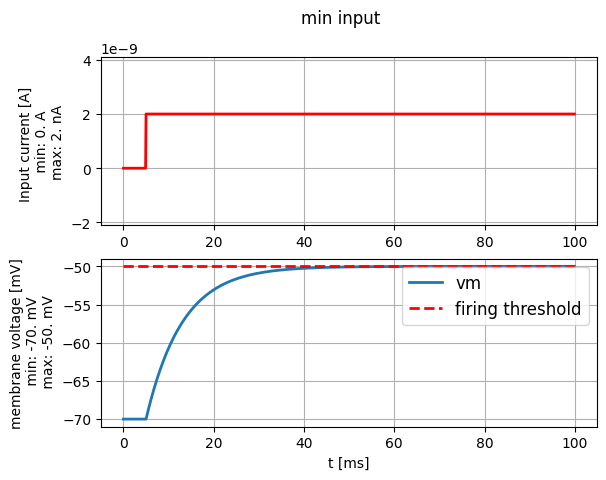

In [16]:
import brian2 as b2
from neurodynex3.leaky_integrate_and_fire import LIF
from neurodynex3.tools import input_factory

# create a step current with amplitude = I_min
step_current = input_factory.get_step_current(
    t_start=5, t_end=100, unit_time=b2.ms,
    amplitude=I_min)  # set I_min to your value

# run the LIF model.
# Note: As we do not specify any model parameters, the simulation runs with the default values
(state_monitor,spike_monitor) = LIF.simulate_LIF_neuron(input_current=step_current, simulation_time = 100 * b2.ms)

# plot I and vm
plot_tools.plot_voltage_and_current_traces(
state_monitor, step_current, title="min input", firing_threshold=LIF.FIRING_THRESHOLD)
print("nr of spikes: {}".format(spike_monitor.count[0]))  # should be 0

## 1.2 Exercise f-I Curve

For a constant input current :math:`I`, a LIF neuron fires regularly with firing frequency :math:`f`. If the current is to small (:math:`I < I_{min}`) :math:`f` is 0Hz; for larger :math:`I` the rate increases. A neuron's firing-rate versus input-amplitude relationship is visualized in an "f-I curve".

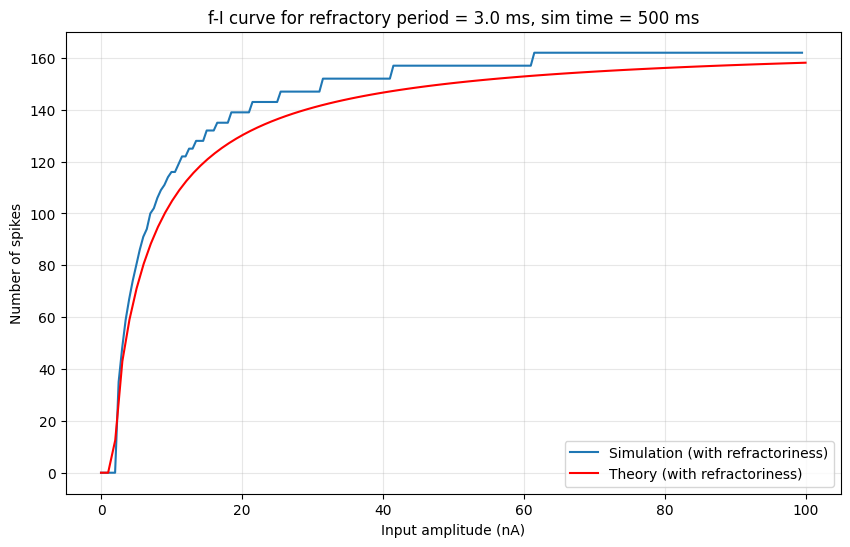

Theoretical I_min = 2.00 nA


In [48]:
start_amp = 0
end_amp = 100
step_amp = 0.5
refactory_period_ms = 3.0
simulation_time_ms = 500
x, y  = [], []

for amp in np.arange(start_amp, end_amp, step_amp):
    print("Simulating for amp: {}/{}".format(amp, end_amp), end="\r")
    step_current = input_factory.get_step_current(
        t_start=0, t_end=simulation_time_ms, unit_time=b2.ms,  # Fixed: current now lasts full simulation
        amplitude=amp * b2.nA)

    (state_monitor, spike_monitor) = LIF.simulate_LIF_neuron(
        input_current=step_current, 
        simulation_time=simulation_time_ms * b2.ms, 
        abs_refractory_period=refactory_period_ms * b2.ms)

    x += [amp]
    y += [spike_monitor.count[0]]


def theoretical_fI_curve(input_amp, refactory_period_ms, simulation_time_ms=500):
    """
    Calculate the theoretical number of spikes for a given input amplitude.
    
    Formula: f = 1 / (tau_ref + tau_m * ln(RI / (RI - (V_th - V_rest))))
    Number of spikes = f * simulation_time
    """
    # Convert to base SI units to avoid Brian2 unit conflicts
    tau_ref = refactory_period_ms * 1e-3  # convert ms to seconds
    tau_m = float(MEMBRANE_TIME_SCALE / b2.second)  # convert to seconds
    R = float(MEMBRANE_RESISTANCE / b2.ohm)  # convert to ohms
    V_th = float(FIRING_THRESHOLD / b2.volt)  # convert to volts
    V_rest = float(V_REST / b2.volt)  # convert to volts
    
    # Handle both single values and arrays
    I = np.asarray(input_amp) * 1e-9  # convert nA to amperes
    
    # Check if input is above threshold
    I_min = (V_th - V_rest) / R
    
    # Initialize output array
    result = np.zeros_like(I)
    
    # Only calculate for currents above threshold
    above_threshold = I > I_min
    I_valid = I[above_threshold]
    
    if len(I_valid) > 0:
        # Calculate firing frequency (Hz)
        frequency = 1 / (tau_ref + tau_m * np.log(R * I_valid / (R * I_valid - (V_th - V_rest))))
        
        # Convert simulation time to seconds and calculate number of spikes
        sim_time_s = simulation_time_ms * 1e-3
        result[above_threshold] = frequency * sim_time_s
    
    # Return scalar if input was scalar
    if np.isscalar(input_amp):
        return float(result)
    return result

x_true = np.linspace(start_amp, end_amp, 100)
y_true_with_ref = theoretical_fI_curve(x_true, refactory_period_ms, simulation_time_ms)

plt.figure(figsize=(10, 6))
plt.plot(x, y, label="Simulation (with refractoriness)")
plt.plot(x_true, y_true_with_ref, 'r-', label="Theory (with refractoriness)")
plt.xlabel("Input amplitude (nA)")
plt.ylabel("Number of spikes")
plt.title("f-I curve for refractory period = {} ms, sim time = {} ms".format(refactory_period_ms, simulation_time_ms))
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print I_min for comparison
I_min_nA = float((FIRING_THRESHOLD - V_REST) / MEMBRANE_RESISTANCE / b2.nA)
print(f"Theoretical I_min = {I_min_nA:.2f} nA")

(<Axes: ylabel='Input current [A] \n min: 0. A \nmax: 5. nA'>,
 <Axes: xlabel='t [ms]', ylabel='membrane voltage [mV]\n min: -60. mV\n max: -48.61578751 mV'>)

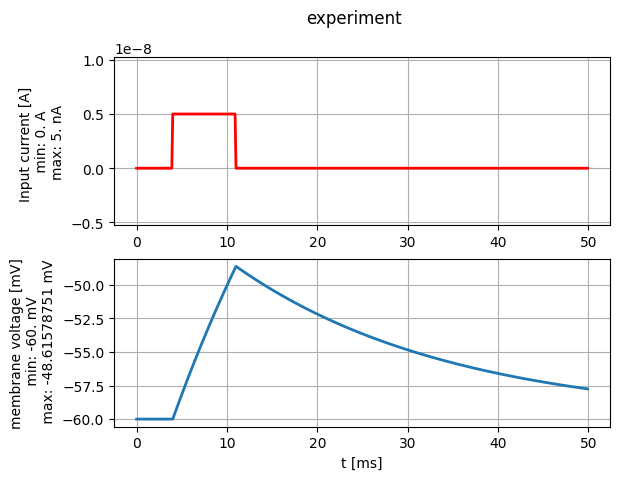

In [61]:
# get a random parameter. provide a random seed to have a reproducible experiment
random_parameters = LIF.get_random_param_set(random_seed=432)

# define your test current
test_current = input_factory.get_step_current(
    t_start=4, t_end=10, unit_time=b2.ms, amplitude= 5 * b2.namp)

# probe the neuron. pass the test current AND the random params to the function
state_monitor, spike_monitor = LIF.simulate_random_neuron(test_current, random_parameters)

# plot
plot_tools.plot_voltage_and_current_traces(state_monitor, test_current, title="experiment")

# print the parameters to the console and compare with your estimates
# LIF.print_obfuscated_parameters(random_parameters)